<div class="alert alert-info">
    Nice! Just one thing: To do a comparison that answers whether the PLA treatments are significantly different than the control, its best to look at the overlap of the credible regions of your posteriors. Laying out the ECDFs next to each other as you have makes its hard to make any quantitative statement about the comparison (-3). 57/60
    </div>

## Problem 8.1: A hierarchical model for cell viability on biomaterials

Attribution: Zhiyang and Maddie coded up this problem together; the whole group discuss together about the way to do the thrid part.

In [1]:
import itertools

import numpy as np
import pandas as pd
import altair as alt
import altair_catplot as altcat

import bebi103

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
color_palette=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

/anaconda/lib/python3.6/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader.bokeh_ext'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

**a)** First we will do some exploratory data analysis to investigate the data set.

Let's first read in the data set and look at how it's organized.

In [2]:
df = pd.read_csv('../data/shao_et_al_wst-1_assay.csv')

# Take a look
df.head()

Treatment Experiment  assay_result
0   Control        One       1.45945
1   Control        One       1.51035
2   Control        One       1.80045
3   Control        One       1.83745
4     PLA_1        One       1.42015

It looks like there are 5 groups, control, PLA_1, PLA_2, PLA_3, and Neg_ctrl. In each experiment, they measured cell viability, and they did three experiments for each group.

Let's plot the cell viabliity by group and color by experiment to look at where the values are.

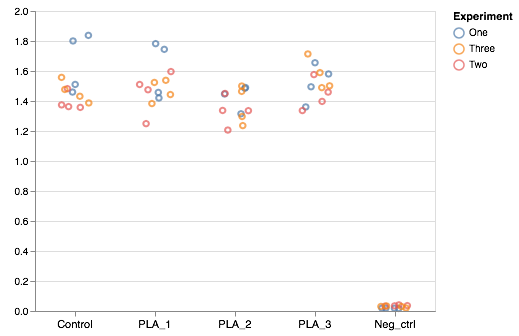

In [3]:
altcat.catplot(data=df,
               mark='point',
               encoding=dict(y=alt.Y('assay_result:Q', title=None),
                             x='Treatment:N', 
                             color=alt.Color('Experiment:N')),
               transform='jitter'
              )

For the control group, the cell viability is around 1.3 to 1.9. For the negative control, the cell viability values are all around 0.01 to 0.04. For the PLA groups, the cell viability values range from 1.2 to 1.8.

There are not many data points in the data set, so plotting ECDF for each experiment might not help illustrate the data better, but we plot the ECDF for each treatment to see if there is a trend to distinguish them from each other since it is not clear in the jitter plot.

In [4]:
p = bebi103.viz.ecdf_collection(data=df, 
                                cats='Treatment',
                                val='assay_result',
                                formal=True,
                                line_width=2,
                                plot_width=600,
                                plot_height=300)

# Compare results from two methods
bokeh.io.show(p)

The negative control is certainly close to zero, while we can see that PLA_2 is slightly different from other non-negative-control treatment, and PLA_1, PLA_3 and Control are very similar with each other. Just as a sanity check, we plot the ECDF for each experiment in the control treatment.

In [5]:
p = bebi103.viz.ecdf_collection(data=df.loc[df['Treatment']=='Control'], 
                                cats='Experiment',
                                val='assay_result',
                                formal=True,
                                line_width=2,
                                plot_width=600,
                                plot_height=300)

# Compare results from two methods
bokeh.io.show(p)

Because of the limited number of data point, the ECDF is not that informative, but we can still see that there are some difference among those experiments, indicating the hierarchical model could be better here for those experiments. We then proceed and build the hierarchical model for those data.

**b)** We'd like to construct a hierarchical model describing the results. For the control, we assume the typical assay value for a viable group of cells is around unity, and we choose a gaussian as our prior. For the PLA groups, we will also choose a gaussian for our prior and make sure to encompass the possibility of all the cells dying as well as thriving. We will use the same prior for the control and PLA groups because we do not know have much information about what the PLA groups will behave and the broad prior could be helpful. For the negative control, however, we know that cells should be dying and assume that the typical baseline (absence of viable cells) does not go much beyond 0.05, so we can use a narrow prior for that. 

The structure of our model for the negative control is shown below:

\begin{gather}
\theta \sim \mbox{HalfNorm}(\sigma_0) \\
\sigma \sim \mbox{HalfNorm}(\sigma_{hyper}) \\
\tau \sim \mbox{HalfNorm}(\tau_{hyper}) \\
\theta_1 \sim \mbox{Norm}(\theta, \tau) \\
y \sim \mbox{Norm}(\theta_1, \sigma)
\end{gather}

, where those $\sigma_0, \sigma_{hyper}, \tau_{hyper}$ as the parameters of the priors are also considered as a input so that we can change the prior easily without re-compiling the Stan code.

Let's do a prior predictive check for the negative control. 

In [6]:
model_code_pri_pred_neg = """
data {
  // Number of data points for each experiment
  int N;
  // Number of entries in each level of the hierarchy
  int J_1;
  // Input of parameters of the priors
  real hyper_theta_mu;
  real hyper_theta_sigma;
  real hyper_sigma;
  real hyper_tau;
}


generated quantities {
  // Total number of data points 
  real n[N * J_1];
  // Priors
  real theta = fabs(normal_rng(hyper_theta_mu, hyper_theta_sigma));
  real sigma = fabs(normal_rng(0, hyper_sigma));
  real tau = fabs(normal_rng(0, hyper_tau));
  // Second layer of the hierarchical model
  real theta_1[J_1];  
  
  for (i in 1:J_1) {
    theta_1[i] = normal_rng(theta, sigma);
    for (j in 1:N) {
      n[(i - 1) * N + j] = normal_rng(theta_1[i], tau);
    }
  }
    
  }
"""

The Stan code is attached above for reference, but the model is compiled from the standalone file.

In [7]:
# Complie from the standalone file
sm_gen = bebi103.stan.StanModel(file='hw81_pri_pred_neg.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa58021fd393a0a5d9ed33a35e6afda6 NOW.


In file included from /var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpljgnqahe/stanfit4anon_model_aa58021fd393a0a5d9ed33a35e6afda6_1828068929782992319.cpp:642:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpljgnqahe/stanfit4anon_model_aa58021fd393a0a5d9ed33a35e6afda6_1828068929782992319.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1::

We then do the prior predictive check for the negative control, where we use very narrow priors, because 1) we do know that the negative control cells should die, 2) we try to avoid negative values from the normal distribution by having narrow priors.

In [8]:
# Number of iteration
N_iter = 1000

# 4 data points per experiments, 3 experiments
data = dict(N=4,
            J_1=3,
            hyper_theta_mu=0,
            hyper_theta_sigma=0.05,
            hyper_sigma=0.01,
            hyper_tau=0.01)

# Sample
df_pred = sm_gen.sampling(data=data,
                     algorithm='Fixed_param',
                     warmup=0,
                     chains=1,
                     iter=N_iter)

df_samples = bebi103.stan.extract_array(df_pred, name='n')

# Plot
bokeh.io.show(
    bebi103.viz.predictive_ecdf(df_pred, 
                                'n', 
                                x_axis_label='assay_result'))

We check the ratio of negative values in the generated data set.

In [9]:
# Number of negative values
num_neg, _ = df_samples.loc[df_samples['n'] < 0].shape
# Total number of data points
num, _ = df_samples.shape
# Ratio of negative values inside the generated data set
num_neg / num

0.06825

It's not too little, but should be okay since we do not care too much about the negative control modeling. We then have the model for other treatment as below 

\begin{gather}
\theta \sim \mbox{Norm}(\mu,\sigma_0) \\
\sigma \sim \mbox{HalfNorm}(\sigma_{hyper}) \\
\tau \sim \mbox{HalfNorm}(\tau_{hyper}) \\
\theta_1 \sim \mbox{Norm}(\theta, \tau) \\
y \sim \mbox{Norm}(\theta_1, \sigma)
\end{gather}

Then we have the Stan code for the model as below.

In [10]:
model_code_pri_pred = """
data {
  // Number of data points for each experiment
  int N;
  // Number of entries in each level of the hierarchy
  int J_1;
  // Input of parameters of the priors
  real hyper_theta_mu;
  real hyper_theta_sigma;
  real hyper_sigma;
  real hyper_tau;
}


generated quantities {
  // Total number of data points 
  real n[N * J_1];
  // Priors
  real theta = normal_rng(hyper_theta_mu, hyper_theta_sigma);
  real sigma = fabs(normal_rng(0, hyper_sigma));
  real tau = fabs(normal_rng(0, hyper_tau));
  // Second layer
  real theta_1[J_1];  
  
  for (i in 1:J_1) {
    theta_1[i] = normal_rng(theta, sigma);
    for (j in 1:N) {
      n[(i - 1) * N + j] = normal_rng(theta_1[i], tau);
    }
  }
    
  }
"""

Compile the stan code from the standalone file.

In [11]:
# Complie from the standalone file
sm_gen = bebi103.stan.StanModel(file='hw81_pri_pred.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0eb23c02f420ea7aa875afa5b19b63b NOW.


In file included from /var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpnaqal1hp/stanfit4anon_model_f0eb23c02f420ea7aa875afa5b19b63b_3111183670215583964.cpp:642:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpnaqal1hp/stanfit4anon_model_f0eb23c02f420ea7aa875afa5b19b63b_3111183670215583964.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1::

Sample and plot results.

In [12]:
# Number of iteration
N_iter = 1000

# 4 data points per experiments, 3 experiments
data = dict(N=4,
            J_1=3,
            hyper_theta_mu=1.,
            hyper_theta_sigma=0.3,
            hyper_sigma=0.1,
            hyper_tau=0.1)

# Sample
df_pred = sm_gen.sampling(data=data,
                     algorithm='Fixed_param',
                     warmup=0,
                     chains=1,
                     iter=N_iter)

df_samples = bebi103.stan.extract_array(df_pred, name='n')

# Plot
bokeh.io.show(
    bebi103.viz.predictive_ecdf(df_pred, 
                                'n', 
                                x_axis_label='assay_result'))

This looks reasonable for the experiments where cells are not all dying. We have some negative values so let's check what fraction of values are negative.

In [13]:
# Number of negative values
num_neg, _ = df_samples.loc[df_samples['n'] < 0].shape
# Total number of data points
num, _ = df_samples.shape
# Ratio of negative values inside the generated data set
num_neg / num

0.0008333333333333334

About 0.1% of the sampled values are negative, which is small enough that we're willing to accept. Let's move on to coding up our centered model with these priors. 

In [14]:
model_code_centered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1;
}


model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1 ~ normal(theta, tau);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

We then use the function in bebi103 to put the data and parameters into the model. We do the control first to check if there is something wrong with the model.

In [15]:
data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']=='Control'],
                                           level_cols=['Experiment'],
                                           data_cols='assay_result')

# Take a look
data

{'N': 12,
 'J_1': 3,
 'index_1': array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
 'assay_result': array([1.45945, 1.51035, 1.80045, 1.83745, 1.43135, 1.38715, 1.47695,
        1.55735, 1.3627 , 1.3741 , 1.3573 , 1.4824 ])}

Then we want to sample out of the posterior.

In [16]:
# Complie from the standalone file
sm_centered = bebi103.stan.StanModel(file='hw81_centered.Stan')

# Sample
samples_centered = sm_centered.sampling(data=data, seed=2389412)

# Convert to data frame for easy use later
df_mcmc_centered = bebi103.stan.to_dataframe(samples_centered)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eaf5549573b52bf69718c7ca68e0d881 NOW.


In file included from /var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmp1e2p_qjg/stanfit4anon_model_eaf5549573b52bf69718c7ca68e0d881_6246453271983197966.cpp:642:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmp1e2p_qjg/stanfit4anon_model_eaf5549573b52bf69718c7ca68e0d881_6246453271983197966.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1::

We run the diagnostics for this model.

In [17]:
bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
97 of 4000 (2.425%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

There are still some iterations with divergences, we can look at the corner plot to see what happened.

In [18]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

It looks like that we have funnel-like distribution here, which is probably why the divergens happened. We then switch to non-centered model to see if we can fix this. Before that, we have a function for further sampling.

In [19]:
def hw81_sampling(sm, df, treat):
    '''Sample out of posterior for certain treatment'''
    data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']==treat],
                                                     level_cols=['Experiment'],
                                                     data_cols='assay_result')
    # Sample with slightly larger adapt_delta
    samples= sm.sampling(data=data, seed=2389412, control=dict(adapt_delta=0.89))
    
    return samples

We want to look at a random treatment just to make sure the function is working well. Let's do PLA_2 here.

In [20]:
samples_centered = hw81_sampling(sm_centered, df, 'PLA_2')

# Diagnostics
bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
303 of 4000 (7.575%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

Still, we've got some divergent points, and we take a look at the corner plot.

In [21]:
# Corner plot
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

Still a funnel-like distribution, we then code the non-cenetered model for non-negative-control treatments. The non-centered model is shown as below.

\begin{gather}
\theta \sim \mbox{Norm}(1,0.3) \\
\sigma \sim \mbox{HalfNorm}(0.1) \\
\tau \sim \mbox{HalfNorm}(0.1) \\
\theta^\sim_1 \sim \mbox{Norm}(0, 1) \\
\theta_1 = \theta + \tau \theta^\sim_1 \\
y \sim \mbox{Norm}(\theta_1, \sigma)
\end{gather}

In [22]:
model_code_noncentered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1_tilde;
}

transformed parameters {
  // Transformations for noncentered
  vector[J_1] theta_1 = theta + tau * theta_1_tilde;
}

model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1_tilde ~ normal(0, 1);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

Compile the stan code from the standalone file.

In [23]:
sm_noncentered = bebi103.stan.StanModel(file='hw81_noncentered.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84f33485e6ca8334b3802247c3f90d50 NOW.


In file included from /var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpak1yjpe5/stanfit4anon_model_84f33485e6ca8334b3802247c3f90d50_7531959876692336678.cpp:642:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmpak1yjpe5/stanfit4anon_model_84f33485e6ca8334b3802247c3f90d50_7531959876692336678.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1::

Sample and run diagnostics.

In [24]:
samples_noncentered = hw81_sampling(sm_noncentered, df, 'Control')

bebi103.stan.check_all_diagnostics(samples_noncentered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

Looks great! Then we can look at the corner plot to see what parameter estimates we have.

In [25]:
bokeh.io.show(bebi103.viz.corner(samples_noncentered, pars=['theta', 'sigma', 'tau']))

The values of $\theta$ look reasonable, and though we do not care too much about the negative control, we still have the non-centered model for that.

In [26]:
model_code_noncentered_neg = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real<lower=0> theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1_tilde;
}

transformed parameters {
  // Transformations for noncentered
  vector[J_1] theta_1 = theta + tau * theta_1_tilde;
}

model {
  theta ~ normal(0, 0.05);
  sigma ~ normal(0, 0.01);
  tau ~ normal(0, 0.01);

  theta_1_tilde ~ normal(0, 1);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

Compile the stan code from the standalone file.

In [27]:
sm_neg = bebi103.stan.StanModel(file='hw81_noncentered_neg.Stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d623e57d8730bfe20285a2bd754c0d18 NOW.


In file included from /var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmp81fhn0tl/stanfit4anon_model_d623e57d8730bfe20285a2bd754c0d18_8404148064305122204.cpp:642:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/w5/3dvb5cqj0lx59zjrblf9vszc0000gn/T/tmp81fhn0tl/stanfit4anon_model_d623e57d8730bfe20285a2bd754c0d18_8404148064305122204.cpp:9397:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1::

Sample and run diagnostics.

In [28]:
samples_neg = hw81_sampling(sm_neg, df, 'Neg_ctrl')

bebi103.stan.check_all_diagnostics(samples_neg)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
3 of 4000 (0.075%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

It looks fine, and we then do the corner plot for parameter estimates.

In [29]:
bokeh.io.show(bebi103.viz.corner(samples_neg, pars=['theta', 'sigma', 'tau']))

Our model looks good now, so we proceed to analyze the ratio of the PLA assay results to control.

**(c)** Using our hierarchical model, we want to compare the ratios of PLA-1/control, PLA-2/control, and PLA-3/control. 

First, we need to generate samples for the three PLA groups. Let's start with PLA_1.

In [30]:
samples_PLA1 = hw81_sampling(sm_noncentered, df, 'PLA_1')

bebi103.stan.check_all_diagnostics(samples_PLA1)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
3 of 4000 (0.075%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

The sampling looks ok, so let's check the corner plot.

In [31]:
bokeh.io.show(bebi103.viz.corner(samples_PLA1, pars=['theta', 'sigma', 'tau']))

It looks fine despite a few divergences, so now let's sample for PLA_2.

In [32]:
samples_PLA2 = hw81_sampling(sm_noncentered, df, 'PLA_2')

bebi103.stan.check_all_diagnostics(samples_PLA2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
2 of 4000 (0.05%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

Looks ok, so let's check the corner plot again.

In [33]:
bokeh.io.show(bebi103.viz.corner(samples_PLA2, pars=['theta', 'sigma', 'tau']))

This also looks ok, so let's sample for PLA_3.

In [34]:
samples_PLA3 = hw81_sampling(sm_noncentered, df, 'PLA_3')

bebi103.stan.check_all_diagnostics(samples_PLA3)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
1 of 4000 (0.025%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

And check the corner plot.

In [35]:
bokeh.io.show(bebi103.viz.corner(samples_PLA3, pars=['theta', 'sigma', 'tau']))

They all look reasonable and not pathological. We then convert the sampling results to data frames.

In [36]:
# Convert stan to dataframe
df_noncentered = bebi103.stan.to_dataframe(samples_noncentered, diagnostics=False, inc_warmup=False)
df_PLA1 = bebi103.stan.to_dataframe(samples_PLA1, diagnostics=False, inc_warmup=False)
df_PLA2 = bebi103.stan.to_dataframe(samples_PLA2, diagnostics=False, inc_warmup=False)
df_PLA3 = bebi103.stan.to_dataframe(samples_PLA3, diagnostics=False, inc_warmup=False)

First, we marginalize and plot the CDFs for each parameter for parameters theta, sigma, and tau as our parameter estimates. Let's start with the control group.

In [37]:
# Marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_noncentered[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

Now let's make the same plots for the experimental groups, starting with PLA_1.

In [38]:
# Marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA1[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

It looks very similar to the control, although the curves are slightly shifted. Interestingly, the shape of tau appears different from PLA_1 to control. Let's now plot the CDFs for PLA_2.

In [39]:
# Marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA2[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

The curves looks very similar in shape to PLA_1. Let's now plot the CDFs for PLA_3.

In [40]:
# Marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA3[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

Again, the curves look similar to PLA_1 and PLA_2.

Since we think we care the most about $\theta$, as it predicts the assay result, and because the noise and variability might not be as important, we would like to compare the ECDFs of those four treatments.

In [41]:
p1 = bebi103.viz.ecdf(df_noncentered['theta'], x_axis_label='theta control', plot_height=200, plot_width=250)
p2 = bebi103.viz.ecdf(df_PLA1['theta'], x_axis_label='theta PLA_1', plot_height=200, plot_width=250)
p3 = bebi103.viz.ecdf(df_PLA2['theta'], x_axis_label='theta PLA_2', plot_height=200, plot_width=250)
p4 = bebi103.viz.ecdf(df_PLA3['theta'], x_axis_label='theta PLA_3', plot_height=200, plot_width=250)

bokeh.io.show(bokeh.layouts.gridplot([p1, p2, p3, p4], ncols=4))

It's hard to compare them directly from those ECDFs since they seem very close to each other. Thanks to MCMC sampling, we can divide the $\theta$ sampled from experimental groups by that samples from the control group directly, and plot the ECDFs of those results.

In [42]:
p1 = bebi103.viz.ecdf(df_PLA1['theta']/df_noncentered['theta'], x_axis_label='theta PLA_1/Control', plot_height=200, plot_width=250)
p2 = bebi103.viz.ecdf(df_PLA2['theta']/df_noncentered['theta'], x_axis_label='theta PLA_2/Control', plot_height=200, plot_width=250)
p3 = bebi103.viz.ecdf(df_PLA3['theta']/df_noncentered['theta'], x_axis_label='theta PLA_3/Control', plot_height=200, plot_width=250)

bokeh.io.show(bokeh.layouts.gridplot([p1, p2, p3], ncols=3))

Here we can see clearly that PLA 1 and PLA3 are centered slightly higher chan control, meaning cells probably can live with those treatments; PLA 2 is centered at less than 1 so it may indciate that PLA2 can still have some detrimental effects on the cell viability though it is minor and not lethal. 

In [43]:
%load_ext watermark

ModuleNotFoundError: No module named 'watermark'

In [ ]:
%watermark -v -p numpy,scipy,bokeh,jupyterlab